# Advanced Modeling for MPG Forecasting
After establishing a baseline model using simple linear regression, it's essential to explore more advanced modeling techniques to enhance prediction accuracy and account for complex patterns in the data. While baseline models offer a solid starting point, they often rely on strong assumptions—such as linear relationships and absence of multicollinearity—which may not fully capture the nuances of real-world data like fuel efficiency (MPG).

In this stage, we introduce a series of increasingly sophisticated models including
1. Linear Regression
2. Ridge Regression
3. Random Forest
4. Gradient Boosting
5. XGBoost

These models are capable of handling non-linear relationships, interactions between variables, and high-dimensional feature spaces. Regularization techniques like Ridge Regression help mitigate overfitting, while ensemble methods such as Random Forest and Gradient Boosting combine the strengths of multiple learners to improve generalization. XGBoost, a highly optimized gradient boosting algorithm, often delivers state-of-the-art performance in structured data problems like this.

By comparing the performance of these models against the baseline, we aim to identify the most reliable and interpretable approach for accurately forecasting miles per gallon, ultimately supporting more informed decisions in vehicle design and policy planning.

## Tasks
- Import Libraries
- Load and Prepare Dataset
    - Load data
    - Split the dataset into input features and target variable
    - Split the dataset into training and testing set
- Advance Modelling
    - Generate Empty Models (Linear Regression, Ridge Regression, Random Forest Regressor, Gradient Boosting Regressor, XGB Regressor)
    - Hyperparameter Grids and Bayesian Search Space
    - Training Models With Hyperparameter Tuning
- Cross Validation
    - Aggregate Best Estimators from Hyperparameter Tuning
    - Evaluate Best Models Using Cross Validation for Training Set
    - Evaluate Best Models Using Cross Validation for Testing Set
- Summarize Model Evaluation Metrics for Training and Testing Set
- Visualize the Model Comparison
- Visualization of Model Prediction
    - Prediction Error Plot
    -  Residuals Plot
- Interprate The Best Model
- Save Results
    - Bar Chart of Model Comparison
    - Best Model as pkl file
- Summary of The Best Model

# Import Libraries

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# visualization libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# model libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from yellowbrick.regressor import PredictionError, ResidualsPlot
import joblib
import shap

# Load and Prepare Data For Modeling

## Load Data

In [2]:
# load preprocessed dataset of mpg
df  = pd.read_csv("data/mpg_cleaned.csv")

## Split the dataset into input features (x) and target variable (y)

In [3]:
# features
x = df.drop('mpg', axis=1)

# target variable
y = df['mpg']

In [4]:
# features
x

,cylinders,horsepower,weight,car_age,origin_japan,origin_usa
0,8,130.0,3504,55,False,True
1,8,165.0,3693,55,False,True
2,8,150.0,3436,55,False,True
3,8,150.0,3433,55,False,True
4,8,140.0,3449,55,False,True
...,...,...,...,...,...,...
387,4,86.0,2790,43,False,True
388,4,52.0,2130,43,False,False
389,4,84.0,2295,43,False,True
390,4,79.0,2625,43,False,True


In [5]:
# target variable
y

0      18.0
1      15.0
2      18.0
3      16.0
4      17.0
       ... 
387    27.0
388    44.0
389    32.0
390    28.0
391    31.0
Name: mpg, Length: 392, dtype: float64

## Split the dataset into training and testing sets

In [6]:
# split data into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Advanced Modeling

In [7]:
# generate empty models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, enable_categorical=True)
}

## Hyperparameter Grids and Bayesian Search Space

In [8]:
# hyperparameter grids
param_grids = {
    "Linear Regression": {
        'fit_intercept': [True, False],
        'positive': [False]
    },

    "Ridge Regression": {
        'alpha': np.logspace(-4, 4, 9),
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },

    "Random Forest": {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },

    "Gradient Boosting Regressor": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },

    "XGBoost": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'subsample': [0.6, 0.8, 1.0]
    }
}

In [9]:
# bayesian search space
bayes_spaces = {
    "Linear Regression" : {
        'fit_intercept' : Categorical([True, False]),
        'positive' : Categorical([False])
    },

    "Ridge Regression" : {
        'alpha' : Real(1e-4, 1e4, prior='log-uniform'),
        'solver' : Categorical(['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    },

    "Random Forest" : {
        'n_estimators' : Integer(50, 150),
        'max_depth' : Integer(5, 30),
        'min_samples_split' : Integer(2, 10),
        'min_samples_leaf' : Integer(1, 4)
    },

    "Gradient Boosting Regressor" : {
        'n_estimators' : Integer(50, 200),
        'learning_rate' : Real(0.01, 0.3, prior='log-uniform'),
        'max_depth' : Integer(3, 10),
        'min_samples_split' : Integer(2, 10),
        'min_samples_leaf' : Integer(1, 4)
    },

    "XGBoost" : {
        'n_estimators' : Integer(50, 150),
        'learning_rate' : Real(0.01, 0.3, prior='log-uniform'),
        'max_depth' : Integer(3, 10),
        'colsample_bytree' : Real(0.5, 1.0),
        'subsample' : Real(0.5, 1.0)
    }
}

##  Training Models with Hyperparameter Tuning

In [10]:
# train models using grid search
grid_search = {}

for model in models:
    grid_search[model] = GridSearchCV(
        estimator=models[model],
        param_grid=param_grids[model],
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1,
    )

    grid_search[model].fit(x_train, y_train)

In [11]:
# train models using random search
random_search = {}

for model in models:
    random_search[model] = RandomizedSearchCV(
        models[model],
        param_grids[model],
        n_iter=20,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )
    
    random_search[model].fit(x_train, y_train)

In [12]:
# train models using bayesian search
bayes_search = {}

for model in models:
    bayes_search[model] = BayesSearchCV(
        models[model],
        bayes_spaces[model],
        n_iter=30,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )

    bayes_search[model].fit(x_train, y_train)

# Cross Validation

## Aggregate Best Estimators from Hyperparameter Tuning

In [13]:
# list of best models
best_models = []

In [14]:
# best models from grid search
for model in models:
    best_models.append({
        "Model": f"{model} (Grid Search)",
        "Estimator": grid_search[model].best_estimator_
    })

In [15]:
# best models from random search
for model in models:
    best_models.append({
            "Model": f"{model} (Random Search)",
            "Estimator": random_search[model].best_estimator_
        })

In [16]:
# best models from bayesian search
for model in models:
    best_models.append({
        "Model": f"{model} (Bayesian Search)",
        "Estimator": bayes_search[model].best_estimator_
    })

## Evaluate Best Models Using Cross-Validation for Training Set

In [17]:
# evaluation results
train_set_evaluation = []

for model in best_models:
    model_name = model["Model"]
    estimator = model["Estimator"]

    # cross-validation based on train data
    scores = cross_validate(
        estimator,
        x_train,
        y_train,
        cv=5,
        scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
    )

    # evaluation metrics
    train_set_evaluation.append({
        "Model": model_name,
        "CV MSE": -scores['test_neg_mean_squared_error'].mean(),
        "CV MAE": -scores['test_neg_mean_absolute_error'].mean(),
        "CV RMSE": np.sqrt(-scores['test_neg_mean_squared_error'].mean()),
        "CV R2": scores['test_r2'].mean()
    })

In [18]:
# display evaluation results
cv_evaluation = pd.DataFrame(train_set_evaluation)

cv_evaluation

,Model,CV MSE,CV MAE,CV RMSE,CV R2
0,Linear Regression (Grid Search),11.777357,2.627755,3.431815,0.812156
1,Ridge Regression (Grid Search),11.744147,2.621644,3.426973,0.812975
2,Random Forest (Grid Search),9.334242,2.205254,3.055199,0.850436
3,Gradient Boosting Regressor (Grid Search),8.732826,2.105042,2.955136,0.859043
4,XGBoost (Grid Search),8.708989,2.145665,2.951100,0.859703
5,Linear Regression (Random Search),11.777357,2.627755,3.431815,0.812156
6,Ridge Regression (Random Search),11.744147,2.621644,3.426973,0.812975
7,Random Forest (Random Search),9.334242,2.205254,3.055199,0.850436
8,Gradient Boosting Regressor (Random Search),8.780826,2.135609,2.963246,0.857315
9,XGBoost (Random Search),9.037032,2.140473,3.006166,0.853665


## Evaluate Best Model on Test Set

In [19]:
# evaluation results
test_set_evaluation = []

for model in best_models:
    model_name = model['Model']
    estimator = model['Estimator']

    # fit the model on the entire training set
    estimator.fit(x_train, y_train)

    # make predictions on the test set
    y_pred = estimator.predict(x_test)

    # evaluation metrics
    test_set_evaluation.append({
        "Model" : model_name,
        "Test MSE" : mean_squared_error(y_test, y_pred),
        "Test MAE" : mean_absolute_error(y_test, y_pred),
        "Test RMSE" : np.sqrt(mean_squared_error(y_test, y_pred)),
        "Test R2" : r2_score(y_test, y_pred)
    })

In [20]:
# display evaluation results
test_evaluation = pd.DataFrame(test_set_evaluation)

test_evaluation

,Model,Test MSE,Test MAE,Test RMSE,Test R2
0,Linear Regression (Grid Search),11.237861,2.518828,3.352292,0.779825
1,Ridge Regression (Grid Search),11.018594,2.483126,3.319427,0.784121
2,Random Forest (Grid Search),6.023639,1.835813,2.454310,0.881983
3,Gradient Boosting Regressor (Grid Search),6.325029,1.919054,2.514961,0.876078
4,XGBoost (Grid Search),6.237007,1.848121,2.497400,0.877803
5,Linear Regression (Random Search),11.237861,2.518828,3.352292,0.779825
6,Ridge Regression (Random Search),11.018594,2.483126,3.319427,0.784121
7,Random Forest (Random Search),6.023639,1.835813,2.454310,0.881983
8,Gradient Boosting Regressor (Random Search),6.884674,1.949801,2.623866,0.865114
9,XGBoost (Random Search),6.811885,1.947273,2.609959,0.866540


## Summarize model evaluation metrics for training and testing sets

In [21]:
# merge and sort by Test R2 Score
summary_df = cv_evaluation.merge(test_evaluation, on='Model')

summary_df = summary_df.sort_values(by='Test R2', ascending=False).reset_index(drop=True)

# display summary of evaluation results
summary_df

,Model,CV MSE,CV MAE,CV RMSE,CV R2,Test MSE,Test MAE,Test RMSE,Test R2
0,Random Forest (Bayesian Search),9.275111,2.204430,3.045507,0.851802,5.903272,1.824995,2.429665,0.884342
1,Random Forest (Random Search),9.334242,2.205254,3.055199,0.850436,6.023639,1.835813,2.454310,0.881983
2,Random Forest (Grid Search),9.334242,2.205254,3.055199,0.850436,6.023639,1.835813,2.454310,0.881983
3,XGBoost (Grid Search),8.708989,2.145665,2.951100,0.859703,6.237007,1.848121,2.497400,0.877803
4,Gradient Boosting Regressor (Grid Search),8.732826,2.105042,2.955136,0.859043,6.325029,1.919054,2.514961,0.876078
5,XGBoost (Bayesian Search),8.470239,2.118925,2.910367,0.863740,6.359562,1.874118,2.521817,0.875402
6,Gradient Boosting Regressor (Bayesian Search),8.590446,2.125531,2.930946,0.860572,6.656080,1.904531,2.579938,0.869592
7,XGBoost (Random Search),9.037032,2.140473,3.006166,0.853665,6.811885,1.947273,2.609959,0.866540
8,Gradient Boosting Regressor (Random Search),8.780826,2.135609,2.963246,0.857315,6.884674,1.949801,2.623866,0.865114
9,Ridge Regression (Grid Search),11.744147,2.621644,3.426973,0.812975,11.018594,2.483126,3.319427,0.784121


# Visualize Model Comparison

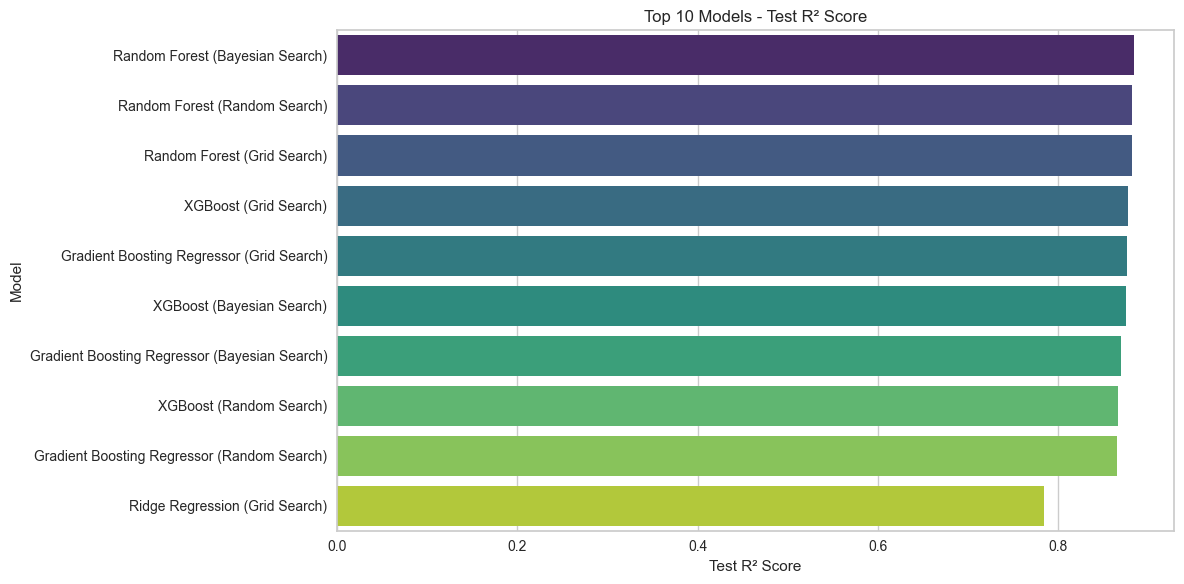

In [22]:
# plot the top 10 models based on Test R2 Score
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df.head(10), x='Test R2', y='Model', palette='viridis')
plt.title('Top 10 Models - Test R² Score')
plt.xlabel('Test R² Score')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

# Visualization of Model Prediction

In [ ]:
# find the best model
best_model_name = summary_df.iloc[0]['Model']

# find the matching estimator in all_best_models
for entry in best_models:
    if entry["Model"] == best_model_name:
        best_model = entry["Estimator"]
        break

print("Best Model:", best_model_name)

Best Model: Random Forest (Bayesian Search)


## Prediction Error Plot

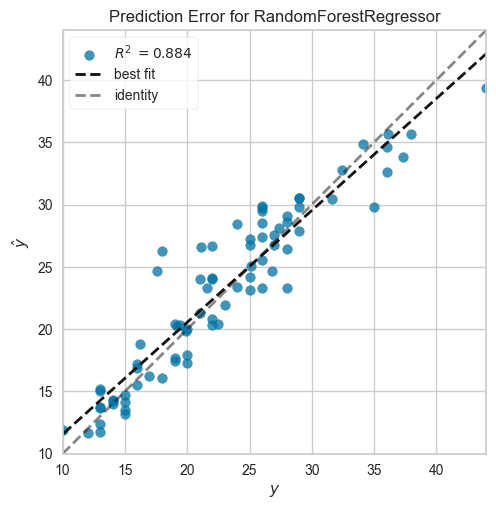

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [ ]:
# prediction error visualization
visualizer = PredictionError(best_model)

# fit the visualizer to the training data
visualizer.fit(x_train, y_train)

# score the visualizer on the test data
visualizer.score(x_test, y_test)

# show the visualization
visualizer.show()

## Residuals Plot

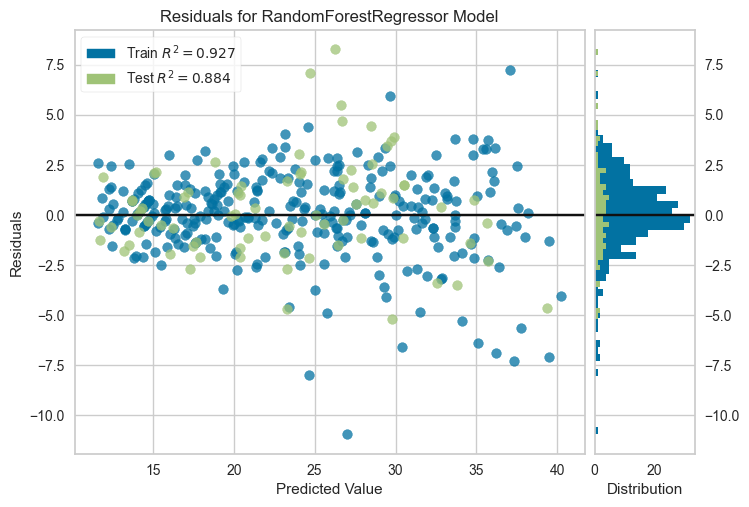

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [ ]:
# residuals plot visualization
visualizer = ResidualsPlot(best_model)

# fit the visualizer to the training data
visualizer.fit(x_train, y_train)

# score the visualizer on the test data
visualizer.score(x_test, y_test)

# show the visualization
visualizer.show()

# Interprate the best Model

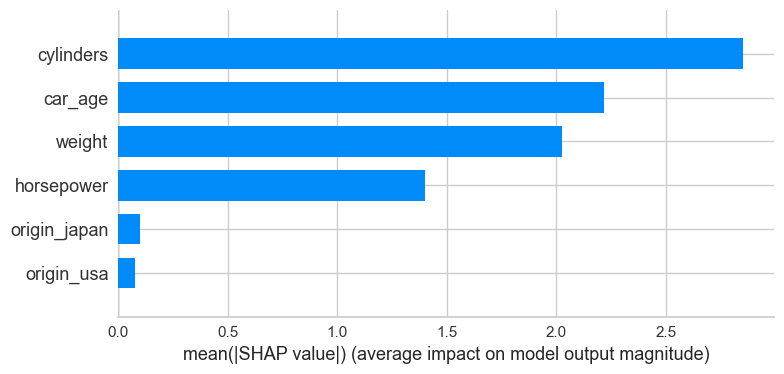

In [ ]:
# explain the model using SHAP
explainer = shap.Explainer(best_model)

# calculate SHAP values for the test set
shap_values = explainer(x_test)

# summary plot of SHAP values
shap.summary_plot(shap_values, x_test, plot_type="bar")

# Save Results

In [27]:
# save the model comparisons
joblib.dump(summary_df, 'reports/model_comparisons.csv')

['reports/model_comparisons.csv']

In [28]:
# save the best model
joblib.dump(best_model, 'reports/forecastingModel.pkl')

['reports/forecastingModel.pkl']

# Summary of The Best Model

In [29]:
print(" Best Model ".center(50, '-'), end='\n\n')
print("Model Name".ljust(10), ":", summary_df.iloc[0]['Model'])
print()
print(" Performance ".center(50, '-'), end='\n\n')
print("Test R2".ljust(10), ":", round(summary_df.iloc[0]['Test R2'], 4))
print("Test RMSE".ljust(10), ":", round(summary_df.iloc[0]['Test RMSE'], 4))

------------------- Best Model -------------------

Model Name : Random Forest (Bayesian Search)

------------------ Performance -------------------

Test R2    : 0.8843
Test RMSE  : 2.4297
